# CIFAKE-based model
In this notebook, we will perform various experiments while training a model on the CIFAKE dataset.

CIFAKE contains around 120k images, which can either be real or AI generated. The images have a 32x32 resolution, so it will be interesting to see if our models can capture the patterns correctly even if the resolution is so low.

In [2]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
import torchvision.transforms as transforms

model_utils.fix_random(42)

In [3]:
train_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train")
test_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test")

val_data, test_data = data_utils.train_test_split(0.5, dataset=test_data)

In [4]:
# import model to finetune
ft_resnet18 = resnet18(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet18, num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet18.to(device)

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])        # normalize pixel values
])

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(ft_resnet18.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, test_dataloader)
model_name = "FTResNet18"

using cuda device


In [5]:
# N.B.: the loss displayed is the testing loss! (not train unless specified)
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet18, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/10
-------------------------------


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

In [6]:
model_utils.test(test_dataloader, ft_resnet18, loss_fn, device)

Test Error:
Accuracy: 74.6%, Avg loss: 0.531957 



(0.5319565451069243, tensor(0.7458, device='cuda:0'))

<class 'list'> <class 'list'>
[tensor(0.5875, device='cuda:0'), tensor(0.6702, device='cuda:0'), tensor(0.7031, device='cuda:0'), tensor(0.7198, device='cuda:0'), tensor(0.7285, device='cuda:0'), tensor(0.7332, device='cuda:0'), tensor(0.7385, device='cuda:0'), tensor(0.7426, device='cuda:0'), tensor(0.7449, device='cuda:0'), tensor(0.7469, device='cuda:0')] [tensor(0.6379, device='cuda:0'), tensor(0.6859, device='cuda:0'), tensor(0.7145, device='cuda:0'), tensor(0.7229, device='cuda:0'), tensor(0.7319, device='cuda:0'), tensor(0.7384, device='cuda:0'), tensor(0.7458, device='cuda:0'), tensor(0.7455, device='cuda:0'), tensor(0.7527, device='cuda:0'), tensor(0.7490, device='cuda:0')]


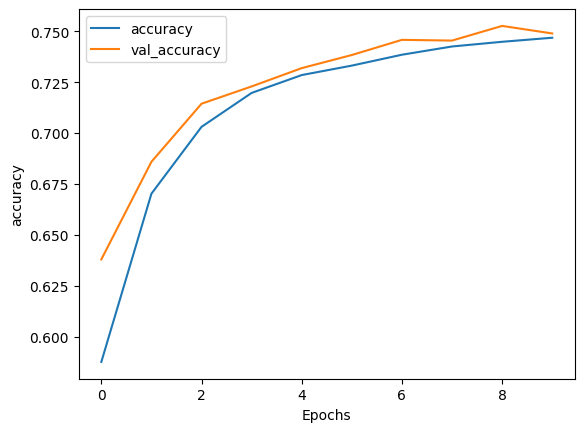

In [17]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy")

ResNet50 with AdamW

In [21]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "FTResNet50"

In [22]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\ASUS\Desktop\ethics_2\ethics_project2\model_utils.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [23]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 82.7%, Avg loss: 0.388036 



(0.3880356218025183, tensor(0.8271, device='cuda:0'))

In [1]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name="FTResNet50")
    plotter.plot_generic_metrics((train_accs, test_accs), "")

NameError: name 'artifacts' is not defined

GradCAM test

In [24]:
import xai

xai.device = device

100%|██████████| 64/64 [00:01<00:00, 53.17it/s]


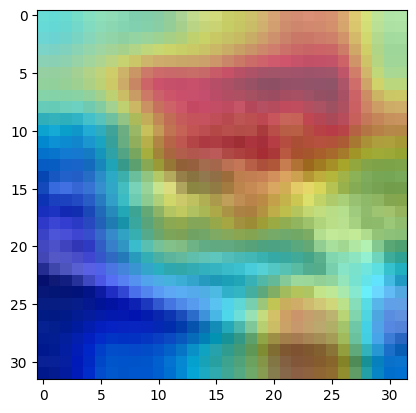

In [26]:
xai.explain_gradcam_single_image(train_dataloader, ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4])

100%|██████████| 1000/1000 [00:01<00:00, 854.69it/s]


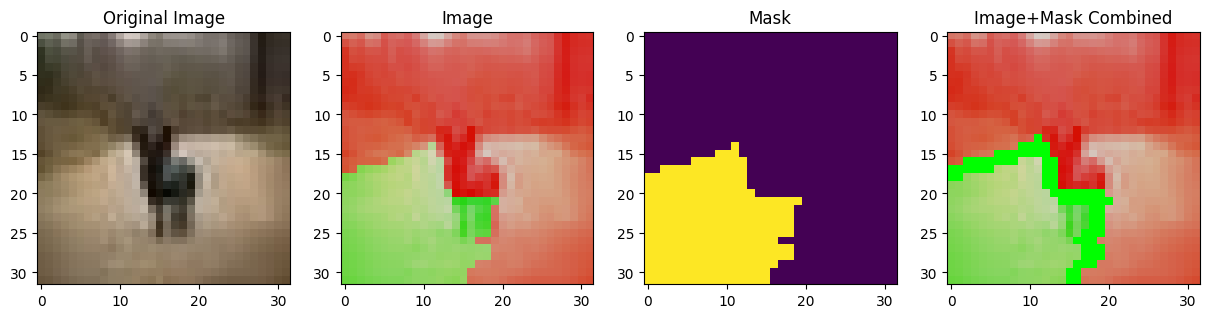

In [29]:
xai.explain_lime_single_image(train_dataloader, ft_resnet50)

TODO: fix lime. I think the problem is in the batch_predict function, which does not give the right prediction

#### Better finetuning of resnet
The classification head has been already finetuned.
time to finetune the feauture extractor.

In [25]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [26]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "FTResNet50_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/10
-------------------------------
training loss: 0.197180, train accuracy: 4.32  [ 5120/100000]
training loss: 0.117130, train accuracy: 9.06  [10240/100000]
training loss: 0.147261, train accuracy: 13.83  [15360/100000]
training loss: 0.121713, train accuracy: 18.60  [20480/100000]
training loss: 0.138992, train accuracy: 23.45  [25600/100000]
training loss: 0.132689, train accuracy: 28.30  [30720/100000]
training loss: 0.083764, train accuracy: 33.15  [35840/100000]
training loss: 0.197115, train accuracy: 38.02  [40960/100000]
training loss: 0.099501, train accuracy: 42.91  [46080/100000]
training loss: 0.280323, train accuracy: 47.80  [51200/100000]
training loss: 0.079485, train accuracy: 52.70  [56320/100000]
training loss: 0.102742, train accuracy: 57.58  [61440/100000]
training loss: 0.128850, train accuracy: 62.50  [66560/100000]
training loss: 0.109865, train accuracy: 67.39  [71680/100000]
training loss: 0.080837, train accuracy: 72.29  [76800/100000]
training loss:

In [27]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 97.4%, Avg loss: 0.082888 



(0.08288750882930816, tensor(0.9738, device='cuda:0'))

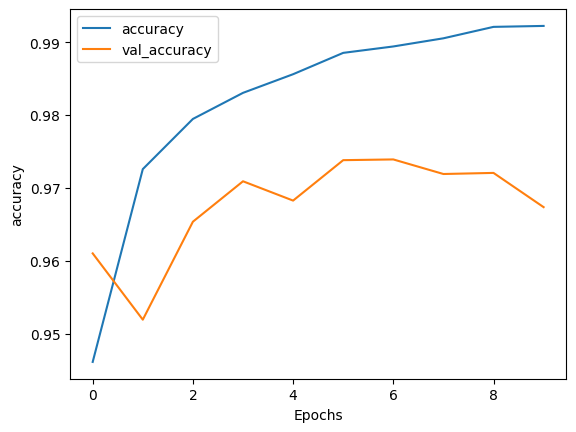

In [28]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy")

### Modified ResNET (3 LL)

In [6]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\galfanol/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.0MB/s]


In [9]:
mod_resnet50.prepare_for_ft()
mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, mod_resnet50.parameters()), lr=0.001
)

In [73]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, "ModResNet50", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

Epoch 1/10
-------------------------------
training loss: 0.589209, train accuracy: 64.49%  [ 5120/100000]
training loss: 0.569063, train accuracy: 69.66%  [10240/100000]
training loss: 0.425489, train accuracy: 71.60%  [15360/100000]
training loss: 0.379870, train accuracy: 73.67%  [20480/100000]
training loss: 0.434049, train accuracy: 74.64%  [25600/100000]
training loss: 0.370602, train accuracy: 75.57%  [30720/100000]
training loss: 0.507435, train accuracy: 76.04%  [35840/100000]
training loss: 0.444904, train accuracy: 76.53%  [40960/100000]
training loss: 0.439364, train accuracy: 76.96%  [46080/100000]
training loss: 0.446686, train accuracy: 77.33%  [51200/100000]
training loss: 0.385277, train accuracy: 77.69%  [56320/100000]
training loss: 0.362237, train accuracy: 77.93%  [61440/100000]
training loss: 0.458711, train accuracy: 78.12%  [66560/100000]
training loss: 0.447777, train accuracy: 78.32%  [71680/100000]
training loss: 0.304927, train accuracy: 78.64%  [76800/10000

In [74]:
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.9%, Avg loss: 0.327365 



(0.32736549901354844, tensor(0.8585, device='cuda:0'))

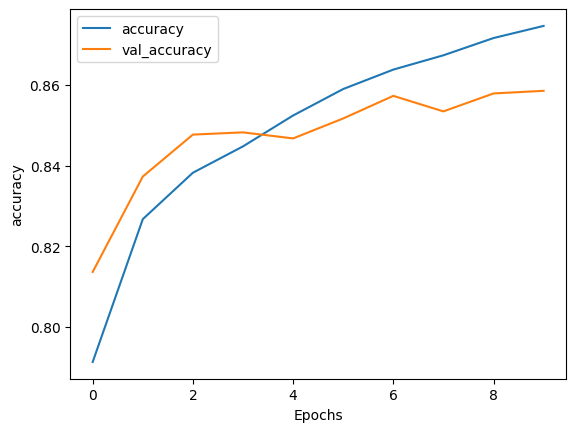

In [75]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy")

#### Finetune 2 strategy on new model

In [7]:
for param in mod_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(mod_resnet50.parameters(), lr=LEARNING_RATE)

In [38]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, "ModResNet50_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

Epoch 1/10
-------------------------------
Training loss: 0.219447, train accuracy: 87.03%  [ 5120/100000]
Training loss: 0.278155, train accuracy: 86.86%  [10240/100000]
Training loss: 0.334328, train accuracy: 87.10%  [15360/100000]
Training loss: 0.375195, train accuracy: 87.09%  [20480/100000]
Training loss: 0.393493, train accuracy: 87.06%  [25600/100000]
Training loss: 0.299072, train accuracy: 86.96%  [30720/100000]
Training loss: 0.364410, train accuracy: 86.97%  [35840/100000]
Training loss: 0.310968, train accuracy: 87.00%  [40960/100000]
Training loss: 0.334603, train accuracy: 87.08%  [46080/100000]
Training loss: 0.329336, train accuracy: 87.10%  [51200/100000]
Training loss: 0.287956, train accuracy: 87.10%  [56320/100000]
Training loss: 0.363872, train accuracy: 87.12%  [61440/100000]
Training loss: 0.379824, train accuracy: 87.07%  [66560/100000]
Training loss: 0.324423, train accuracy: 87.03%  [71680/100000]
Training loss: 0.278499, train accuracy: 87.05%  [76800/10000

Test Error:
Accuracy: 85.9%, Avg loss: 0.330901
Confusion matrix report, tp: 8668, fp: 1332, fn: 1484, tn:8516


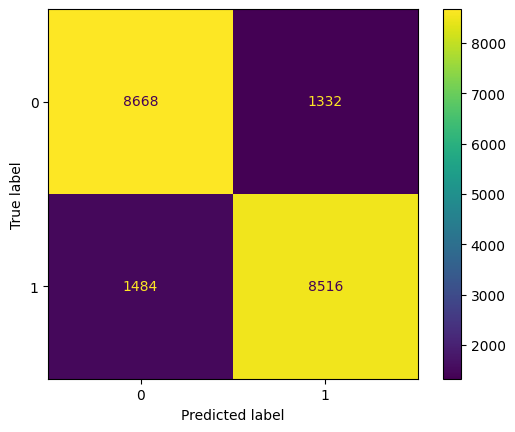

Precision: 0.87, Recall: 0.85, F1-Score: 0.86


(0.3309011220172712, tensor(0.8592, device='cuda:0'))

In [43]:
model_name = "ModResNet50_beefy"
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device, model_name=model_name, visualize=True)

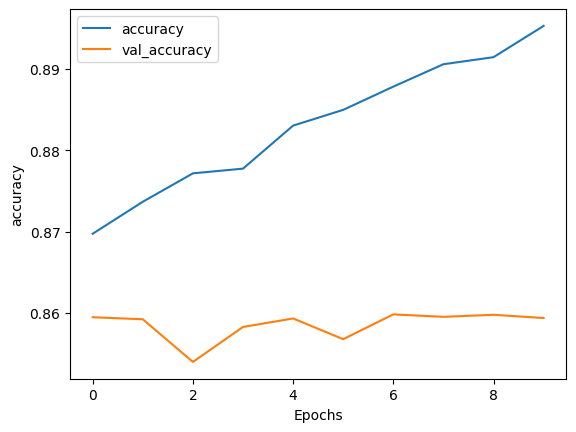

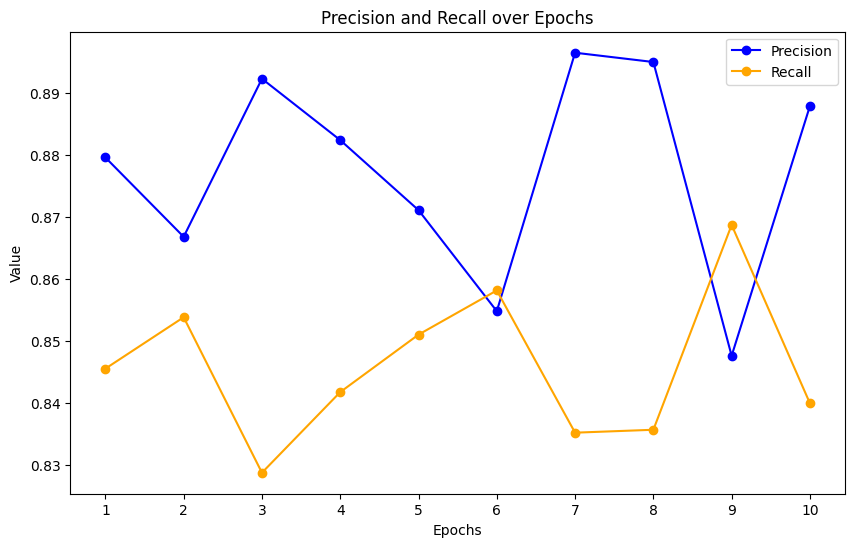

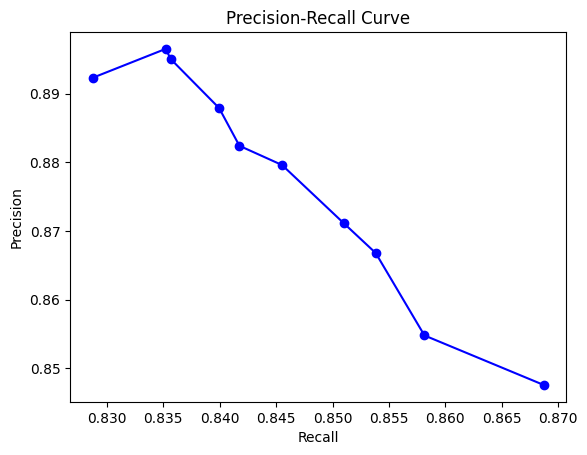

In [41]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Dropout experiment

In [80]:
dp_mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))
dp_mod_resnet50.prepare_for_ft()
dp_mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, dp_mod_resnet50.parameters()), lr=0.001
)

In [81]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, "Dropout_ModResNet50", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

Epoch 1/10
-------------------------------
training loss: 0.475594, train accuracy: 69.43%  [ 5120/100000]
training loss: 0.513834, train accuracy: 73.59%  [10240/100000]
training loss: 0.494731, train accuracy: 75.07%  [15360/100000]
training loss: 0.423828, train accuracy: 75.96%  [20480/100000]
training loss: 0.500044, train accuracy: 76.37%  [25600/100000]
training loss: 0.373807, train accuracy: 76.92%  [30720/100000]
training loss: 0.542084, train accuracy: 77.34%  [35840/100000]
training loss: 0.353532, train accuracy: 77.66%  [40960/100000]
training loss: 0.421613, train accuracy: 77.94%  [46080/100000]
training loss: 0.413494, train accuracy: 78.22%  [51200/100000]
training loss: 0.383588, train accuracy: 78.39%  [56320/100000]
training loss: 0.369964, train accuracy: 78.61%  [61440/100000]
training loss: 0.380268, train accuracy: 78.79%  [66560/100000]
training loss: 0.370058, train accuracy: 78.90%  [71680/100000]
training loss: 0.396780, train accuracy: 79.02%  [76800/10000

In [82]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.7%, Avg loss: 0.332408 



(0.33240787447637815, tensor(0.8565, device='cuda:0'))

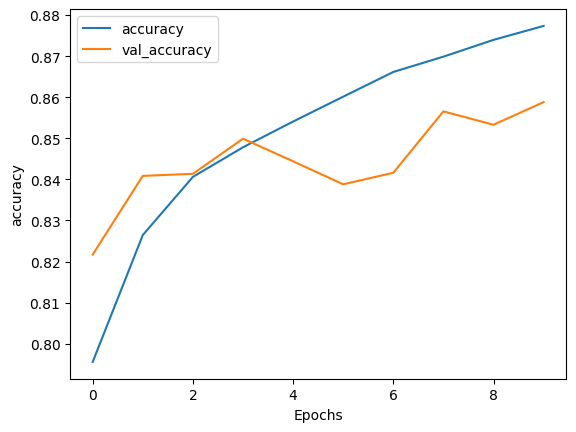

In [83]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy")

#### FT2 with dropout experiment

In [84]:
for param in dp_mod_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(dp_mod_resnet50.parameters(), lr=0.001)

In [85]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, "Dropout_ModResNet50_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

Epoch 1/10
-------------------------------
training loss: 0.317160, train accuracy: 82.27%  [ 5120/100000]
training loss: 0.199223, train accuracy: 86.71%  [10240/100000]
training loss: 0.258081, train accuracy: 88.61%  [15360/100000]
training loss: 0.127835, train accuracy: 89.92%  [20480/100000]
training loss: 0.149454, train accuracy: 90.75%  [25600/100000]
training loss: 0.178936, train accuracy: 91.27%  [30720/100000]
training loss: 0.125429, train accuracy: 91.69%  [35840/100000]
training loss: 0.118678, train accuracy: 91.93%  [40960/100000]
training loss: 0.160212, train accuracy: 92.19%  [46080/100000]
training loss: 0.068440, train accuracy: 92.41%  [51200/100000]
training loss: 0.091584, train accuracy: 92.64%  [56320/100000]
training loss: 0.170910, train accuracy: 92.78%  [61440/100000]
training loss: 0.083679, train accuracy: 92.89%  [66560/100000]
training loss: 0.122279, train accuracy: 93.03%  [71680/100000]
training loss: 0.162463, train accuracy: 93.17%  [76800/10000

In [86]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device)

Test Error:
Accuracy: 96.6%, Avg loss: 0.091687 



(0.09168661918467397, tensor(0.9661, device='cuda:0'))

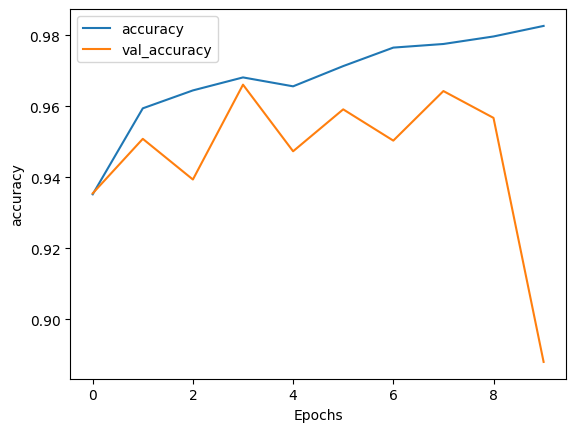

In [87]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy")